In [17]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Data Loading
TRAIN_DATA = np.array(pd.read_csv('mnist_train.csv'))
TEST_DATA = np.array(pd.read_csv('mnist_test.csv'))

# Constants and Data Handling
DATA_SIZE = len(TRAIN_DATA)
BATCH_INDICES = list(range(0, DATA_SIZE))

def shuffle_batch():
    random.shuffle(BATCH_INDICES)

def get_label(sample):
    return int(sample[0])

def get_features(sample):
    return sample[1:][np.newaxis, :] / 255.0

def get_one_hot(label, num_classes=10):
    one_hot = np.zeros((1, num_classes))
    one_hot[0, label] = 1
    return one_hot

In [19]:
# Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Network Operations
def initialize_model():
    # He initialization for ReLU activation
    weights784 = np.random.randn(784, 512) * np.sqrt(2.0/784)
    bias512 = np.zeros((1, 512))
    
    weights512 = np.random.randn(512, 256) * np.sqrt(2.0/512)
    bias256 = np.zeros((1, 256))
    
    weights256 = np.random.randn(256, 128) * np.sqrt(2.0/256)
    bias128 = np.zeros((1, 128))
    
    weights128 = np.random.randn(128, 64) * np.sqrt(2.0/128)
    bias64 = np.zeros((1, 64))
    
    weights64 = np.random.randn(64, 10) * np.sqrt(2.0/64)
    bias10 = np.zeros((1, 10))
    return [weights784, weights512, weights256, weights128, weights64], [bias512, bias256, bias128, bias64, bias10]

def forward_pass(X, weights, biases, store_intermediates=False):
    # More efficient implementation with ReLU activations for 5-layer network
    Z1 = np.dot(X, weights[0]) + biases[0]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights[1]) + biases[1]
    A2 = relu(Z2)
    Z3 = np.dot(A2, weights[2]) + biases[2]
    A3 = relu(Z3)
    Z4 = np.dot(A3, weights[3]) + biases[3]
    A4 = relu(Z4)
    Z5 = np.dot(A4, weights[4]) + biases[4]
    A5 = softmax(Z5)
    
    if store_intermediates:
        return A5, [(Z1, A1), (Z2, A2), (Z3, A3), (Z4, A4), (Z5, A5)]
    return A5

def compute_loss(y_pred, y_true):
    # Cross-entropy loss
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
    return np.sum(log_likelihood) / m

def backward_pass(X, y, weights, biases, intermediates):
    m = X.shape[0]
    Z1, A1 = intermediates[0]
    Z2, A2 = intermediates[1]
    Z3, A3 = intermediates[2]
    Z4, A4 = intermediates[3]
    Z5, A5 = intermediates[4]
    
    # Gradients for output layer
    dZ5 = A5 - y
    dW5 = np.dot(A4.T, dZ5) / m
    db5 = np.sum(dZ5, axis=0, keepdims=True) / m
    
    # Gradients for fourth hidden layer
    dA4 = np.dot(dZ5, weights[4].T)
    dZ4 = dA4 * relu_derivative(Z4)
    dW4 = np.dot(A3.T, dZ4) / m
    db4 = np.sum(dZ4, axis=0, keepdims=True) / m
    
    # Gradients for third hidden layer
    dA3 = np.dot(dZ4, weights[3].T)
    dZ3 = dA3 * relu_derivative(Z3)
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m
    
    # Gradients for second hidden layer
    dA2 = np.dot(dZ3, weights[2].T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    # Gradients for first hidden layer
    dA1 = np.dot(dZ2, weights[1].T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return [dW1, dW2, dW3, dW4, dW5], [db1, db2, db3, db4, db5]

def update_parameters(weights, biases, weight_grads, bias_grads, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * weight_grads[i]
        biases[i] -= learning_rate * bias_grads[i]
    return weights, biases

In [32]:
# Training Function
def training(data_size, epochs, batch_size, learning_rate, data, weights, biases, internal_test=True, logs=True):
    batches = data_size // batch_size
    if logs:
        print(f'Commencing Training with:\nEpochs: {epochs}\nBatches: {batches}\nBatch Size: {batch_size}')
    
    total_time = time.time()
    
    for epoch in range(epochs):
        epoch_time = time.time()
        shuffle_batch()
        
        for batch in range(batches):
            # Process full batch at once
            batch_start = batch * batch_size
            batch_end = batch_start + batch_size
            batch_indices = BATCH_INDICES[batch_start:batch_end]
            
            batch_samples = data[batch_indices]
            batch_labels = np.array([get_label(sample) for sample in batch_samples])
            batch_features = np.vstack([get_features(sample) for sample in batch_samples])
            batch_one_hot = np.zeros((batch_size, 10))
            batch_one_hot[np.arange(batch_size), batch_labels] = 1
            
            # Forward pass
            y_pred, intermediates = forward_pass(batch_features, weights, biases, store_intermediates=True)
            
            # Backward pass
            weight_grads, bias_grads = backward_pass(batch_features, batch_one_hot, weights, biases, intermediates)
            
            # Update parameters
            weights, biases = update_parameters(weights, biases, weight_grads, bias_grads, learning_rate)
        
        if logs:
            print(f'EPOCH {epoch} complete in {time.time() - epoch_time:.2f}(s)')
            if internal_test: 
                testing(TEST_DATA, weights, biases, logs)
    
    if logs:
        print(f'TRAINING COMPLETE in time: {time.time() - total_time:.2f}(s)')
    
    return weights, biases

def testing(data, weights, biases, logs=True):
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    test_batch_size = 100  # Process in batches for efficiency
    num_batches = len(data) // test_batch_size
    
    correct_predictions = 0
    total_samples = len(data)
    
    for i in range(num_batches):
        start_idx = i * test_batch_size
        end_idx = min(start_idx + test_batch_size, total_samples)
        batch_indices = indices[start_idx:end_idx]
        
        batch_samples = data[batch_indices]
        batch_labels = np.array([get_label(sample) for sample in batch_samples])
        batch_features = np.vstack([get_features(sample) for sample in batch_samples])
        
        # Forward pass
        predictions = forward_pass(batch_features, weights, biases)
        predicted_labels = np.argmax(predictions, axis=1)
        
        # Count correct predictions
        correct_predictions += np.sum(predicted_labels == batch_labels)
    
    # Handle remaining samples
    if total_samples % test_batch_size > 0:
        start_idx = num_batches * test_batch_size
        batch_indices = indices[start_idx:]
        
        batch_samples = data[batch_indices]
        batch_labels = np.array([get_label(sample) for sample in batch_samples])
        batch_features = np.vstack([get_features(sample) for sample in batch_samples])
        
        predictions = forward_pass(batch_features, weights, biases)
        predicted_labels = np.argmax(predictions, axis=1)
        
        correct_predictions += np.sum(predicted_labels == batch_labels)
    
    accuracy = correct_predictions / total_samples
    
    if logs:
        print(f'Accuracy: {accuracy * 100:.2f}% ({correct_predictions} / {total_samples})')
        print('---------------------------------')
    
    return accuracy

def find_optimal_parameters(train_data, test_data):
    best_lr = None
    best_accuracy = 0
    results = {}
    
    for lr in np.arange(0.01, 0.21, 0.01):
        weights, biases = initialize_model()
        
        print(f'Testing learning rate: {lr:.3f}')
        weights, biases = training(len(train_data), 3, 64, lr, train_data, weights, biases, False, False)
        acc = testing(test_data, weights, biases, False)
        results[lr] = acc
        
        print(f'Learning Rate: {lr:.3f}, Accuracy: {acc*100:.2f}%')
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_lr = lr
    
    print(f'Best learning rate was {best_lr:.3f} with an accuracy of {best_accuracy*100:.2f}%')
    
    # Plot results
    learning_rates = list(results.keys())
    accuracies = [results[lr]*100 for lr in learning_rates]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(learning_rates, accuracies)
    plt.plot(learning_rates, accuracies, 'b-')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Learning Rate')
    plt.grid(True)
    plt.show()
    
    return best_lr

In [31]:
# Initialize and train model
print(f'Data processing, shuffling batch of size {len(BATCH_INDICES)}.')
start = time.time()
shuffle_batch()
shuffle_time = time.time() - start
print(f'Data shuffling complete, took {shuffle_time:.2f} seconds.')

# Training parameters
DATA_SIZE = len(TRAIN_DATA)
EPOCHS = 8
BATCH_SIZE = 64  # Larger batch size for better vectorization
LEARNING_RATE = 0.1

# Initialize and train the model
WEIGHTS, BIASES = initialize_model()

WEIGHTS, BIASES = training(DATA_SIZE, EPOCHS, BATCH_SIZE, LEARNING_RATE, TRAIN_DATA, WEIGHTS, BIASES, True, True)


Data processing, shuffling batch of size 59999.
Data shuffling complete, took 0.02 seconds.
Commencing Training with:
Epochs: 8
Batches: 937
Batch Size: 64
EPOCH 0 complete in 6.04(s)
Accuracy: 95.83% (9582 / 9999)
---------------------------------
EPOCH 1 complete in 6.14(s)
Accuracy: 97.17% (9716 / 9999)
---------------------------------
EPOCH 2 complete in 6.20(s)
Accuracy: 97.45% (9744 / 9999)
---------------------------------
EPOCH 3 complete in 6.12(s)
Accuracy: 97.61% (9760 / 9999)
---------------------------------
EPOCH 4 complete in 6.17(s)
Accuracy: 97.95% (9794 / 9999)
---------------------------------
EPOCH 5 complete in 6.15(s)
Accuracy: 97.67% (9766 / 9999)
---------------------------------
EPOCH 6 complete in 6.34(s)
Accuracy: 97.70% (9769 / 9999)
---------------------------------
EPOCH 7 complete in 6.22(s)
Accuracy: 98.08% (9807 / 9999)
---------------------------------
TRAINING COMPLETE in time: 51.61(s)


Testing learning rate: 0.010
Learning Rate: 0.010, Accuracy: 94.96%
Testing learning rate: 0.020
Learning Rate: 0.020, Accuracy: 96.13%
Testing learning rate: 0.030
Learning Rate: 0.030, Accuracy: 96.79%
Testing learning rate: 0.040
Learning Rate: 0.040, Accuracy: 96.84%
Testing learning rate: 0.050
Learning Rate: 0.050, Accuracy: 96.74%
Testing learning rate: 0.060
Learning Rate: 0.060, Accuracy: 97.17%
Testing learning rate: 0.070
Learning Rate: 0.070, Accuracy: 97.38%
Testing learning rate: 0.080
Learning Rate: 0.080, Accuracy: 97.51%
Testing learning rate: 0.090
Learning Rate: 0.090, Accuracy: 97.51%
Testing learning rate: 0.100
Learning Rate: 0.100, Accuracy: 97.48%
Testing learning rate: 0.110
Learning Rate: 0.110, Accuracy: 97.42%
Testing learning rate: 0.120
Learning Rate: 0.120, Accuracy: 97.48%
Testing learning rate: 0.130
Learning Rate: 0.130, Accuracy: 97.57%
Testing learning rate: 0.140
Learning Rate: 0.140, Accuracy: 97.57%
Testing learning rate: 0.150
Learning Rate: 0.15

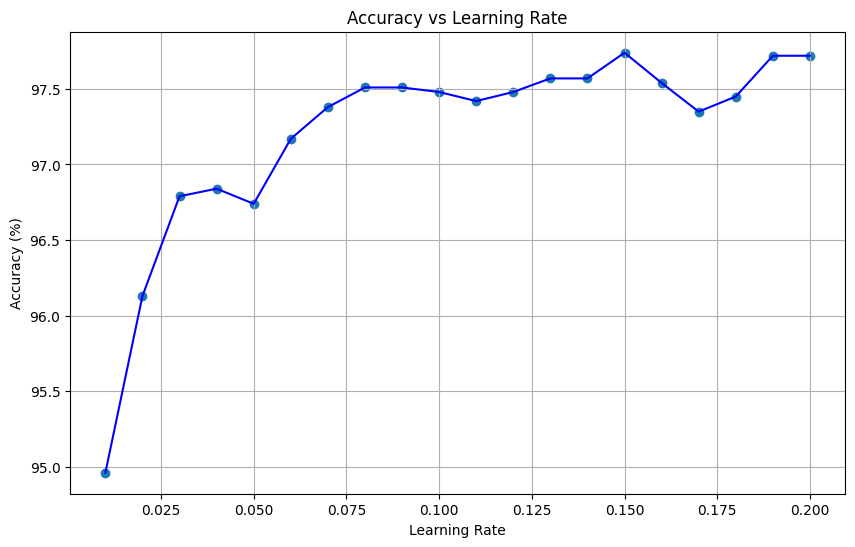

np.float64(0.15000000000000002)

In [33]:
find_optimal_parameters(TRAIN_DATA, TEST_DATA)